In [1]:
# load general tools
import sys
from IPython.display import display
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.precision', 2)
pd.set_option('display.max_colwidth', 50)

In [5]:
# load magine specific tools
from magine.networks.annotated_set import create_subnetwork
import magine.networks.visualization.notebooks.view as view
from magine.enrichment import load_enrichment_csv

from magine.plotting.venn_diagram_maker import create_venn2
from magine.plotting.wordcloud_tools import create_wordcloud

from magine.networks.utils import trim_sink_source_nodes, delete_disconnected_network
from magine.networks.visualization.igraph_viz import paint_network_overtime
from magine.networks.subgraphs import Subgraph
from magine.enrichment.enrichr import db_types

In [7]:
from exp_data import exp_data
network = nx.read_gpickle('Data/cisplatin_network_w_attributes.p')
net_sub = Subgraph(network)

# Exploring enrichment output

Here we load in the results from enrichR

In [10]:
enrichment_array = load_enrichment_csv('Data/cisplatin_enrichment.csv.gz', index_col=0)
enrichment_array['significant'] = False
enrichment_array.loc[enrichment_array['adj_p_value']<=0.05, 'significant'] = True

In [11]:
all_data = enrichment_array.filter_multi(
    p_value=0.05, # only sig pvalues
    combined_score=1.0, # score threshold of positive values 
    db=[ 'Reactome_2016'],
#         category=['rna_up', 'rna_down']
    category=['proteomics_up', 'proteomics_down']
)
print(db_types['pathways'],)
all_data['term_name'] = all_data['term_name'].str.split('_').str.get(0)


['KEGG_2016', 'WikiPathways_2016', 'Reactome_2016', 'BioCarta_2016', 'NCI-Nature_2016', 'Panther_2016']


In [14]:
all_data.remove_redundant(inplace=True, level='sample', threshold=.75)
all_data.remove_redundant(inplace=True, level='dataframe', threshold=.75)
print(all_data.shape)
all_data.require_n_sig(
    columns='sample_id', 
    index=['term_name', 'category'],
    n_sig=2, 
    inplace=True
)
print(all_data.shape)

Number of rows went from 40 to 40
Number of rows went from 40 to 40
(167, 11)
(167, 11)


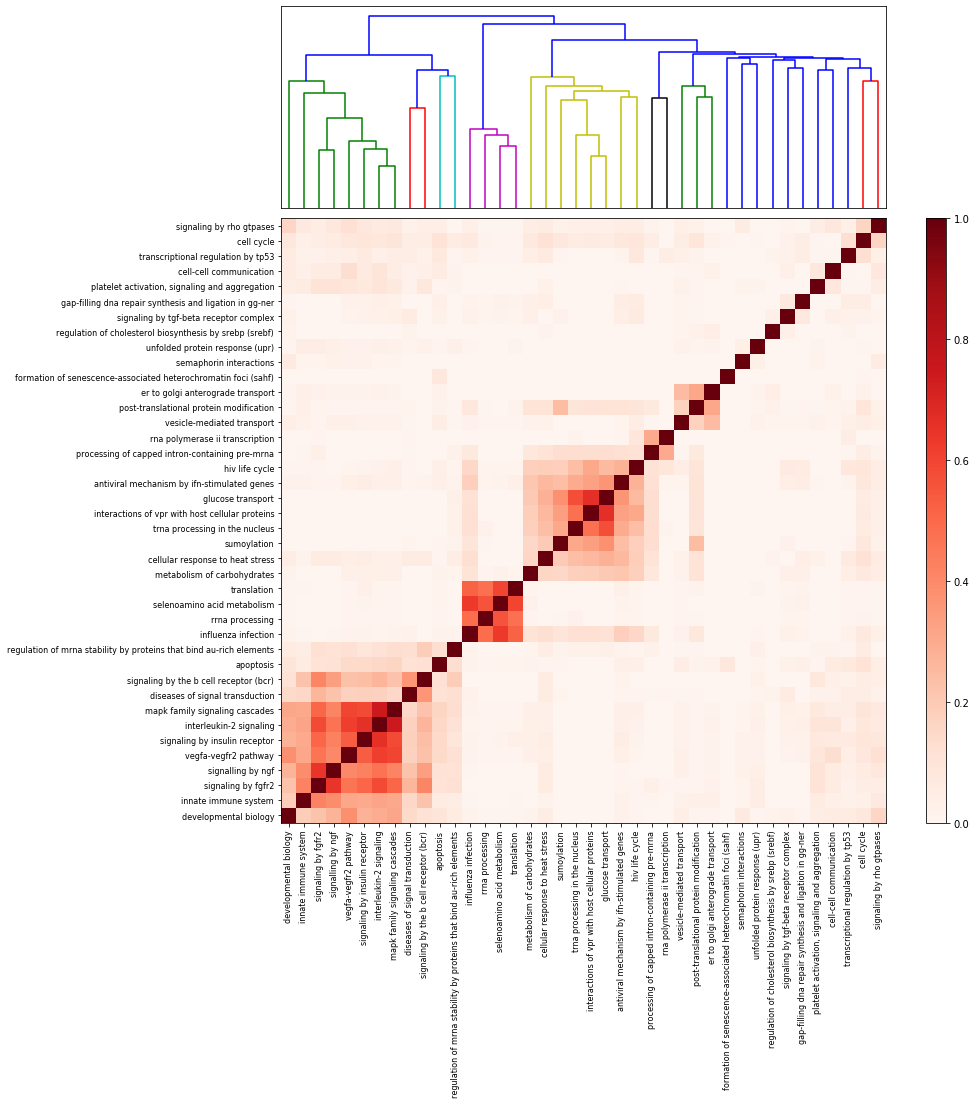

In [16]:
all_data.dist_matrix(level='sample', figsize=(14,14));

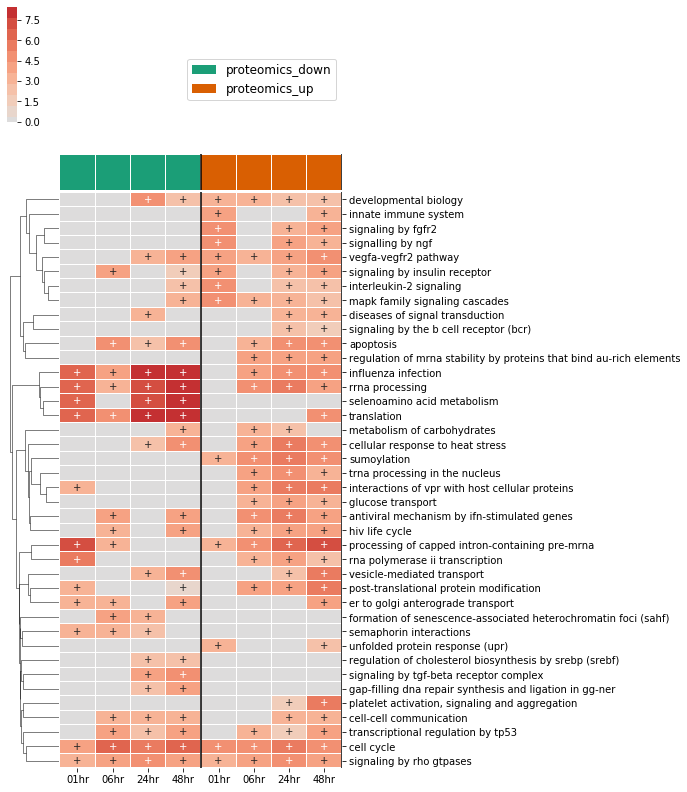

In [18]:
all_data.heatmap(convert_to_log=True, index='term_name',
                 columns=['category', 'sample_id'],
                 figsize=(6,14), annotate_sig=True, linewidths=.01,
                 cluster_row=True, cluster_by_set=True);

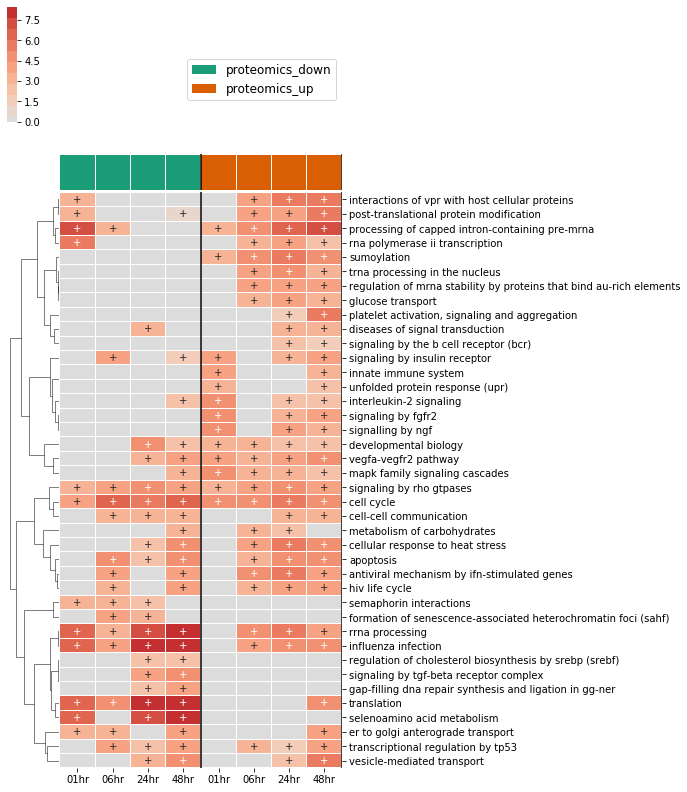

In [19]:
all_data.heatmap(convert_to_log=True, index='term_name',
                 columns=['category', 'sample_id'],
                 figsize=(6,14), annotate_sig=True, linewidths=.01,
                 cluster_row=True);

In [20]:
display(enrichment_array.head(5))

,term_name,rank,combined_score,adj_p_value,genes,n_genes,sample_id,category,db,significant_flag,significant
0,camptothecin-up,1,30.97,1.68e-04,"ACSL3,BZW1,CACYBP,CSE1L,CUL3,DAZAP1,EEF1B2,EIF...",36,01hr,proteomics_both,DrugMatrix,True,True
1,allyl_alcohol-dn,2,23.38,8.17e-03,"ARPC1A,CARHSP1,CHD4,CIC,CUL3,DAZAP1,EEF1B2,FBL...",29,01hr,proteomics_both,DrugMatrix,True,True
2,podophyllotoxin-up,3,22.84,5.85e-03,"ARPC1A,COX5A,DKC1,EEF1B2,FBL,HDAC1,IMMT,MARCKS...",32,01hr,proteomics_both,DrugMatrix,True,True
3,aminosalicylic_acid-up,4,20.91,1.13e-02,"ACSL4,BZW1,CCT2,COX5A,CUL3,EEF1B2,EIF2S2,GCLM,...",28,01hr,proteomics_both,DrugMatrix,True,True
4,mestranol-up,5,20.90,7.66e-03,"ACSL4,BZW1,CCT2,EEF1B2,EIF2S2,HSD17B2,IMMT,IPO...",28,01hr,proteomics_both,DrugMatrix,True,True


In [21]:
# clean up printing by selecting fewer columns
cols = ['term_name', 'rank', 'combined_score', 'n_genes', 'genes', 'sample_id']

In [22]:
display(enrichment_array[cols].head(5))

,term_name,rank,combined_score,n_genes,genes,sample_id
0,camptothecin-up,1,30.97,36,"ACSL3,BZW1,CACYBP,CSE1L,CUL3,DAZAP1,EEF1B2,EIF...",01hr
1,allyl_alcohol-dn,2,23.38,29,"ARPC1A,CARHSP1,CHD4,CIC,CUL3,DAZAP1,EEF1B2,FBL...",01hr
2,podophyllotoxin-up,3,22.84,32,"ARPC1A,COX5A,DKC1,EEF1B2,FBL,HDAC1,IMMT,MARCKS...",01hr
3,aminosalicylic_acid-up,4,20.91,28,"ACSL4,BZW1,CCT2,COX5A,CUL3,EEF1B2,EIF2S2,GCLM,...",01hr
4,mestranol-up,5,20.90,28,"ACSL4,BZW1,CCT2,EEF1B2,EIF2S2,HSD17B2,IMMT,IPO...",01hr


## Data stats

In [23]:
# column types
print(enrichment_array.dtypes)

term_name            object
rank                  int64
combined_score      float64
adj_p_value         float64
genes                object
n_genes               int64
sample_id            object
category             object
db                   object
significant_flag       bool
significant            bool
dtype: object


In [24]:
# databases 
print(sorted(enrichment_array['db'].unique()))

['ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'BioCarta_2016', 'BioPlex_2017', 'ChEA_2016', 'DrugMatrix', 'Drug_Perturbations_from_GEO_2014', 'ENCODE_Histone_Modifications_2015', 'ENCODE_TF_ChIP-seq_2015', 'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X', 'ESCAPE', 'Enrichr_Submissions_TF-Gene_Coocurrence', 'Epigenomics_Roadmap_HM_ChIP-seq', 'GO_Biological_Process_2017b', 'GO_Cellular_Component_2017b', 'GO_Molecular_Function_2017b', 'Genome_Browser_PWMs', 'Human_Phenotype_Ontology', 'Jensen_COMPARTMENTS', 'Jensen_DISEASES', 'KEA_2015', 'KEGG_2016', 'MGI_Mammalian_Phenotype_2017', 'NCI-Nature_2016', 'OMIM_Disease', 'OMIM_Expanded', 'Panther_2016', 'Phosphatase_Substrates_from_DEPOD', 'Reactome_2016', 'TF-LOF_Expression_from_GEO', 'TRANSFAC_and_JASPAR_PWMs', 'Transcription_Factor_PPIs', 'WikiPathways_2016']


In [26]:
# filter only sig terms
sig = enrichment_array.sig.copy()

## Filtering and searching the dataframe

In [27]:
# Filter by terms
d = sig.filter_based_on_words(['death'])
display(d.sort_values('combined_score', ascending=False).head(5))

,term_name,rank,combined_score,adj_p_value,genes,n_genes,sample_id,category,db,significant_flag,significant
458050,premature_death,10,63.16,2.25e-04,"ACTN4,AGR2,AKAP12,APC,APOE,APP,APRT,ARID4A,BAD...",112,48hr,proteomics_both,MGI_Mammalian_Phenotype_2017,True,True
207284,premature_death,4,56.42,3.08e-03,"AGRN,AKAP10,AKAP12,APC,APP,ATN1,ATR,BCL2L11,CA...",69,06hr,proteomics_both,MGI_Mammalian_Phenotype_2017,True,True
897496,premature_death,8,44.86,9.29e-03,"ACTN4,AKAP12,APC,APOE,BAD,BRCA2,CCDC88A,CD47,C...",59,48hr,proteomics_up,MGI_Mammalian_Phenotype_2017,True,True
464255,programmed cell death_hsa_r-hsa-5357801,44,43.94,8.02e-10,"ACIN1,ADD1,APC,BAD,BCAP31,CLSPN,CTNNB1,DBNL,DC...",43,48hr,proteomics_both,Reactome_2016,True,True
1344135,premature_death,11,40.60,1.17e-02,"AGR2,APC,APP,APRT,ARID4A,BICC1,BICD2,CD2AP,CHO...",67,48hr,proteomics_down,MGI_Mammalian_Phenotype_2017,True,True


In [28]:
drug_dbs = ['DrugMatrix', 'Drug_Perturbations_from_GEO_2014']
drug = enrichment_array.filter_multi(
    p_value=0.05,
    combined_score=0.0, 
    db=drug_dbs,
    rank=100,
    #category='rna_up',
)

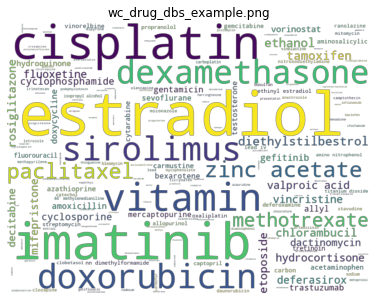

In [29]:
word_cloud = create_wordcloud(drug)
word_cloud.plot('wc_drug_dbs_example.png');

In [30]:
word_cloud.data.head(10)

,words,counts
36,estradiol,183
81,imatinib,121
98,cisplatin,105
82,vitamin,69
78,doxorubicin,53
84,sirolimus,51
89,dexamethasone,48
312,zinc acetate,47
93,paclitaxel,43
80,methotrexate,42


# Single database exploration

Here we will focus on the Reactome enrichment.

In [31]:
reactome_only = enrichment_array.filter_multi(
    p_value=0.05, # only sig pvalues
    combined_score=0.0, # score threshold of positive values 
    db='Reactome_2016', # Only reactome db
    category='proteomics_up', # from this category
    rank=100, # select top 100 from each time point
)

In [32]:
# This cleans up the term name
display(reactome_only['term_name'].head(5))
reactome_only['term_name'] = reactome_only['term_name'].str.split('_').str.get(0)
display(reactome_only['term_name'].head(5))

561738                         cell cycle_hsa_r-hsa-1640170
561739             interleukin-2 signaling_hsa_r-hsa-451927
561740    interleukin-3, 5 and gm-csf signaling_hsa_r-hs...
561741                  cell cycle, mitotic_hsa_r-hsa-69278
561742    interleukin receptor shc signaling_hsa_r-hsa-9...
Name: term_name, dtype: object

561738                               cell cycle
561739                  interleukin-2 signaling
561740    interleukin-3, 5 and gm-csf signaling
561741                      cell cycle, mitotic
561742       interleukin receptor shc signaling
Name: term_name, dtype: object

In [33]:
d = reactome_only.filter_based_on_words(['apop'])
display(d.sort_values('combined_score', ascending=False).head(15)[cols])

,term_name,rank,combined_score,n_genes,genes,sample_id
784066,apoptosis,25,36.84,26,"ACIN1,ADD1,BAD,CASP3,DBNL,DIABLO,DSP,GSN,LMNA,...",24hr
902600,apoptosis,34,27.67,23,"ACIN1,APC,BAD,BCAP31,CTNNB1,DCC,DFFA,FAS,GSN,L...",48hr
784087,apoptotic cleavage of cellular proteins,46,26.15,12,"ACIN1,ADD1,CASP3,DBNL,DSP,GSN,LMNA,LMNB1,PLEC,...",24hr
902620,apoptotic cleavage of cellular proteins,54,18.57,10,"ACIN1,APC,BCAP31,CTNNB1,GSN,LMNA,PLEC,SPTAN1,T...",48hr
784115,apoptotic execution phase,74,17.52,12,"ACIN1,ADD1,CASP3,DBNL,DSP,GSN,LMNA,LMNB1,PLEC,...",24hr
902634,apoptotic execution phase,68,15.69,11,"ACIN1,APC,BCAP31,CTNNB1,DFFA,GSN,LMNA,PLEC,SPT...",48hr
668628,apoptosis,95,7.19,11,"ACIN1,ADD1,PAK2,PLEC,PSMA5,PSMB3,PSMD1,SPTAN1,...",06hr
561827,apoptotic cleavage of cellular proteins,90,5.23,4,"APC,DBNL,LMNA,PLEC",01hr


It is interesting that at the first time point, *apoptotic cleavage of cellular proteins* is up-regulated. Further inspecting this, we find proteins such as ACIN1

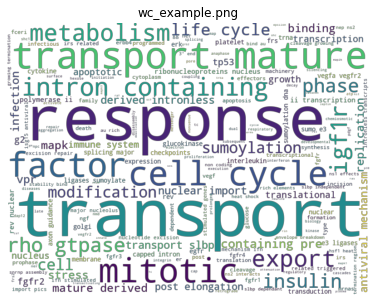

In [34]:
# we can use a word cloud to view what terms are enriched
word_cloud = create_wordcloud(reactome_only)
word_cloud.plot('wc_example.png');

In [35]:
display(reactome_only[cols].head(15))

,term_name,rank,combined_score,n_genes,genes,sample_id
561738,cell cycle,1,36.51,28,"ACD,AKAP9,BRCA1,CDC16,CDC20,CDC7,CLASP2,DCTN1,...",01hr
561739,interleukin-2 signaling,2,30.22,16,"AKAP9,BRAF,CNKSR2,CUL3,HAVCR2,INPPL1,IRS2,MAPK...",01hr
561740,"interleukin-3, 5 and gm-csf signaling",3,29.30,16,"AKAP9,BRAF,CNKSR2,CUL3,INPPL1,IRS2,MAPK3,MARK3...",01hr
561741,"cell cycle, mitotic",4,27.73,22,"AKAP9,CDC16,CDC20,CDC7,CLASP2,DCTN1,HAUS8,HDAC...",01hr
561742,interleukin receptor shc signaling,5,27.24,15,"AKAP9,BRAF,CNKSR2,CUL3,INPPL1,IRS2,MAPK3,MARK3...",01hr
561743,mapk family signaling cascades,6,26.44,16,"AKAP9,BRAF,CNKSR2,CUL3,DNAJB1,IRS2,MAPK3,MARK3...",01hr
561744,signaling by fgfr2,7,25.92,18,"AKAP9,BRAF,CNKSR2,CUL3,HNRNPA1,HNRNPM,INSR,IRS...",01hr
561745,insulin receptor signalling cascade,8,25.79,16,"AKAP9,BRAF,CNKSR2,CUL3,INSR,IRS2,MAPK3,MARK3,P...",01hr
561746,signalling by ngf,9,25.78,21,"AKAP13,AKAP9,ARHGEF16,BRAF,CNKSR2,CUL3,HDAC1,I...",01hr
561747,signaling by interleukins,10,24.45,19,"AKAP9,BRAF,CNKSR2,CUL3,HAVCR2,INPPL1,IRS2,MAP3...",01hr


,rank,combined_score,adj_p_value,n_genes
count,373.00,373.00,3.73e+02,373.00
mean,47.73,22.74,4.59e-03,19.67
std,27.86,15.77,8.92e-03,17.33
min,1.00,5.23,4.39e-21,4.00
25%,24.00,12.57,1.18e-05,11.00
50%,47.00,18.69,8.31e-04,15.00
75%,71.00,26.74,4.07e-03,22.00
max,100.00,116.21,4.84e-02,152.00


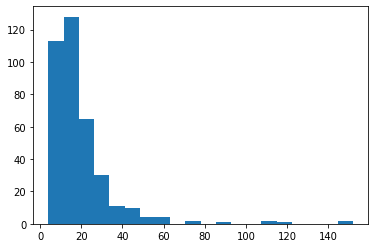

In [36]:
# let's look at the sizes of genes per term
plt.hist(reactome_only['n_genes'], bins=20)
display(reactome_only.describe())

In [37]:
display(reactome_only.sort_values('n_genes', ascending=False)[cols].head(30))
display(reactome_only.sort_values('n_genes', ascending=False)[cols].head(30)['term_name'].values)

,term_name,rank,combined_score,n_genes,genes,sample_id
784043,gene expression,2,102.14,152,"AIMP2,ANP32A,ATF2,ATR,BNIP3L,BOP1,C2ORF49,CD3E...",24hr
902569,gene expression,3,92.14,147,"ANP32A,APEH,BAZ1B,BDP1,BOP1,CD3EAP,CD44,CDK12,...",48hr
902615,metabolism,49,19.91,118,"ABCC1,ACAA1,AKR1B15,ALB,ALDOA,APOA1,APOC3,APOE...",48hr
784141,metabolism,100,10.04,109,"AASDHPPT,ABCA1,ABCC1,ACACA,ACLY,ADO,AGPS,AIMP2...",24hr
902571,metabolism of proteins,5,82.65,108,"APEH,APOA1,ARF4,ATP5A1,ATP5B,CALR,CANX,CD59,CK...",48hr
668534,gene expression,1,55.51,91,"AEBP2,ANP32A,ATF2,ATR,BMS1,BOP1,CPSF2,CPSF3,DA...",06hr
784111,metabolism of proteins,70,18.28,75,"ADD1,CALR,CANX,CCT3,CCT6A,CD59,COPA,DPH1,DYNC1...",24hr
902572,disease,6,56.88,71,"ALB,AP2B1,APC,BAD,BANF1,CALR,CANX,CD9,CHMP7,CT...",48hr
784071,disease,30,34.19,63,"ACACA,BAD,BANF1,CALR,CANX,CLTA,CNTRL,EEF2,EGFR...",24hr
784046,cell cycle,5,62.05,62,"AKAP9,ATR,BANF1,CEP131,CNTRL,DIDO1,DKC1,DYNC1H...",24hr


array(['gene expression', 'gene expression', 'metabolism', 'metabolism',
       'metabolism of proteins', 'gene expression',
       'metabolism of proteins', 'disease', 'disease', 'cell cycle',
       'hemostasis', 'post-translational protein modification',
       'vesicle-mediated transport', 'cell cycle', 'cell cycle, mitotic',
       'metabolism of proteins',
       'processing of capped intron-containing pre-mrna',
       'membrane trafficking',
       'processing of capped intron-containing pre-mrna',
       'cytokine signaling in immune system', 'axon guidance',
       'immune system', 'infectious disease', 'axon guidance',
       'post-translational protein modification', 'infectious disease',
       'mrna splicing - major pathway', 'signaling by rho gtpases',
       'mrna splicing', 'signalling by ngf'], dtype=object)

In [38]:
# Manually select terms with large number of genes that are not useful.
# This is based on person intuition. "Gene expression" and "metabolism" might be useful for some, but 
# here I will elimate as they are not descriptive enough to explain what the drug is doing.

not_useful = ['metabolism', 'gene expression',
              'metabolism of proteins', 'disease',
              'infectious disease', 'immune system',
              'metabolism of amino acids and derivatives',
              'major pathway of rrna processing in the nucleolus',
              'influenza life cycle', 'developmental biology',
              'processing of capped intron-containing pre-mrna',
              'mrna splicing - major pathway',
              'mrna splicing - minor pathway',
              'innate immune system', 'cell-cell communication',
              'diseases of signal transduction', 'mrna splicing'
             ]

In [39]:
reactome_only = reactome_only.loc[~reactome_only['term_name'].isin(not_useful)]

display(reactome_only.sort_values('n_genes', ascending=False)[cols].head(15))

,term_name,rank,combined_score,n_genes,genes,sample_id
784046,cell cycle,5,62.05,62,"AKAP9,ATR,BANF1,CEP131,CNTRL,DIDO1,DKC1,DYNC1H...",24hr
902574,hemostasis,8,52.39,60,"ACTN1,ACTN4,AHSG,ALB,ALDOA,APOA1,APOH,ATP1B1,B...",48hr
902577,post-translational protein modification,11,48.63,56,"ARF4,CALR,CANX,CD59,COPA,COPG2,DAD1,DDOST,DERL...",48hr
902575,vesicle-mediated transport,9,50.49,55,"ALB,APOA1,APOE,ARF4,CALR,CD59,CHMP7,COPA,COPG2...",48hr
784051,"cell cycle, mitotic",10,50.94,51,"AKAP9,BANF1,CEP131,CNTRL,DYNC1H1,EMD,ERCC6L,GO...",24hr
902589,cell cycle,23,32.75,51,"BANF1,BRCA2,CDK4,DKC1,EMD,GORASP2,KIF23,LEMD3,...",48hr
902581,membrane trafficking,15,42.05,47,"ARF4,CD59,CHMP7,COPA,COPG2,EXOC3,EXOC7,FTH1,FT...",48hr
784135,cytokine signaling in immune system,94,11.19,44,"AKAP9,CAMK2D,CASP3,EGFR,EIF4A3,EIF4G3,FLNB,IQG...",24hr
902617,axon guidance,51,19.73,43,"ABL2,ACTR3,AP2B1,ARHGEF28,ARPC1A,DAB2IP,DCC,DO...",48hr
784117,axon guidance,76,15.74,41,"ABL2,ABLIM1,AKAP9,ARHGEF11,ARHGEF7,CAMK2D,CAP1...",24hr


In [40]:
# Now lets look at the first time point. 

test_df = reactome_only.filter_multi(sample_id='01hr')
display(test_df.head(10)[cols])
display(test_df.head(10)[cols].term_name.values)

,term_name,rank,combined_score,n_genes,genes,sample_id
561738,cell cycle,1,36.51,28,"ACD,AKAP9,BRCA1,CDC16,CDC20,CDC7,CLASP2,DCTN1,...",01hr
561739,interleukin-2 signaling,2,30.22,16,"AKAP9,BRAF,CNKSR2,CUL3,HAVCR2,INPPL1,IRS2,MAPK...",01hr
561740,"interleukin-3, 5 and gm-csf signaling",3,29.30,16,"AKAP9,BRAF,CNKSR2,CUL3,INPPL1,IRS2,MAPK3,MARK3...",01hr
561741,"cell cycle, mitotic",4,27.73,22,"AKAP9,CDC16,CDC20,CDC7,CLASP2,DCTN1,HAUS8,HDAC...",01hr
561742,interleukin receptor shc signaling,5,27.24,15,"AKAP9,BRAF,CNKSR2,CUL3,INPPL1,IRS2,MAPK3,MARK3...",01hr
561743,mapk family signaling cascades,6,26.44,16,"AKAP9,BRAF,CNKSR2,CUL3,DNAJB1,IRS2,MAPK3,MARK3...",01hr
561744,signaling by fgfr2,7,25.92,18,"AKAP9,BRAF,CNKSR2,CUL3,HNRNPA1,HNRNPM,INSR,IRS...",01hr
561745,insulin receptor signalling cascade,8,25.79,16,"AKAP9,BRAF,CNKSR2,CUL3,INSR,IRS2,MAPK3,MARK3,P...",01hr
561746,signalling by ngf,9,25.78,21,"AKAP13,AKAP9,ARHGEF16,BRAF,CNKSR2,CUL3,HDAC1,I...",01hr
561747,signaling by interleukins,10,24.45,19,"AKAP9,BRAF,CNKSR2,CUL3,HAVCR2,INPPL1,IRS2,MAP3...",01hr


array(['cell cycle', 'interleukin-2 signaling',
       'interleukin-3, 5 and gm-csf signaling', 'cell cycle, mitotic',
       'interleukin receptor shc signaling',
       'mapk family signaling cascades', 'signaling by fgfr2',
       'insulin receptor signalling cascade', 'signalling by ngf',
       'signaling by interleukins'], dtype=object)

There are 76 enriched terms. If we look at the top ranked terms, we see that some fo them have similar descriptions "Interlekin...". If we look at the gene list, we can also see that some of the genes are similar. To see if there are redundant terms that are enriched, we can calculate their similarity with the Jaccard Index (intersection over union).
![width=50](https://wikimedia.org/api/rest_v1/media/math/render/svg/eaef5aa86949f49e7dc6b9c8c3dd8b233332c9e7)
<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png" alt="Drawing" style="width: 300px;"/>

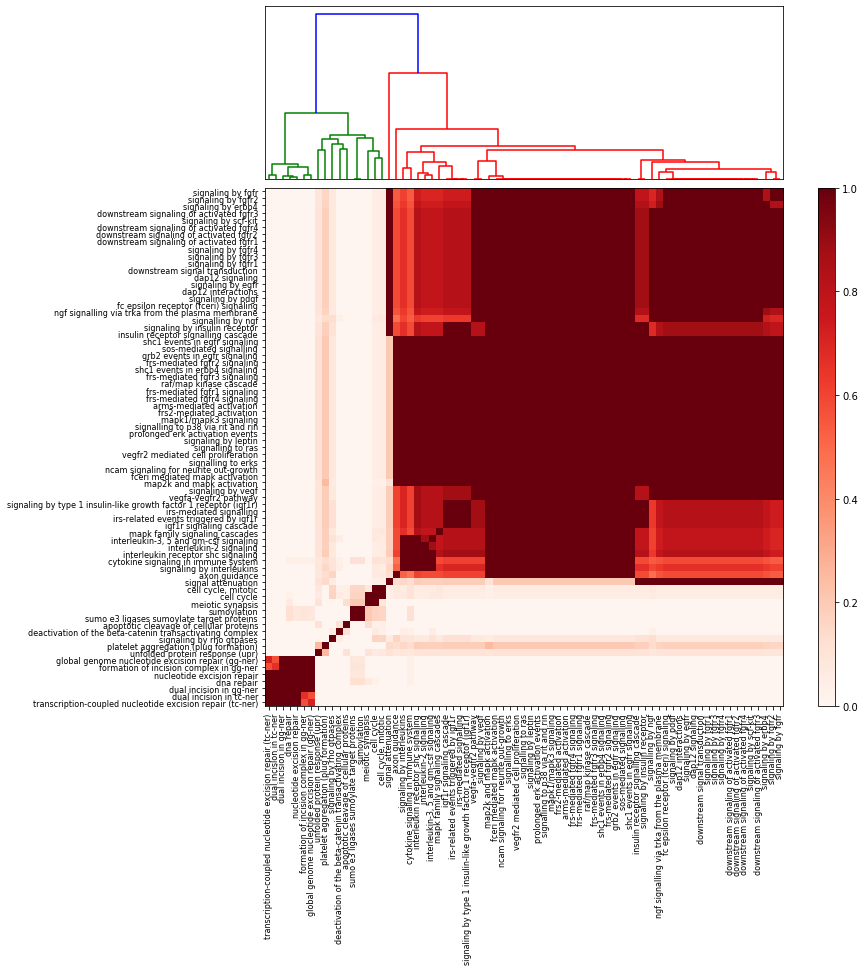

In [42]:
test_df.dist_matrix(figsize=(12,12));

In [43]:
# Valculate the Jaccard Index and returns a ranked dataframe of terms and scores.
# Higher scores means more similar terms
d = test_df.find_similar_terms('cell cycle')
display(d.head(10))

,term_name,similarity_score
2,"cell cycle, mitotic",1.00
67,meiotic synapsis,1.00
58,sumo e3 ligases sumoylate target proteins,0.17
63,signaling by rho gtpases,0.17
61,sumoylation,0.17
57,cytokine signaling in immune system,0.11
1,"interleukin-3, 5 and gm-csf signaling",0.07
4,mapk family signaling cascades,0.07
8,signaling by interleukins,0.07
7,signalling by ngf,0.07


In [44]:
d = test_df.find_similar_terms('interleukin-2 signaling')
display(d.head(10))

,term_name,similarity_score
20,arms-mediated activation,1.0
15,shc1 events in erbb4 signaling,1.0
28,vegfr2 mediated cell proliferation,1.0
27,signalling to ras,1.0
26,signaling by leptin,1.0
25,prolonged erk activation events,1.0
24,signalling to p38 via rit and rin,1.0
23,mapk1/mapk3 signaling,1.0
22,frs2-mediated activation,1.0
21,map2k and mapk activation,1.0


In [45]:
d = test_df.find_similar_terms('mapk family signaling cascades')
display(d.head(10))

,term_name,similarity_score
19,frs-mediated fgfr4 signaling,1.0
14,frs-mediated fgfr2 signaling,1.0
28,vegfr2 mediated cell proliferation,1.0
27,signalling to ras,1.0
26,signaling by leptin,1.0
25,prolonged erk activation events,1.0
24,signalling to p38 via rit and rin,1.0
23,mapk1/mapk3 signaling,1.0
22,frs2-mediated activation,1.0
21,map2k and mapk activation,1.0


We can do this for all terms and view the results in a distance matrix.

The dark red represents terms that are highly similar. We can filter all highly similar terms from the matrix.

Number of rows went from 73 to 12


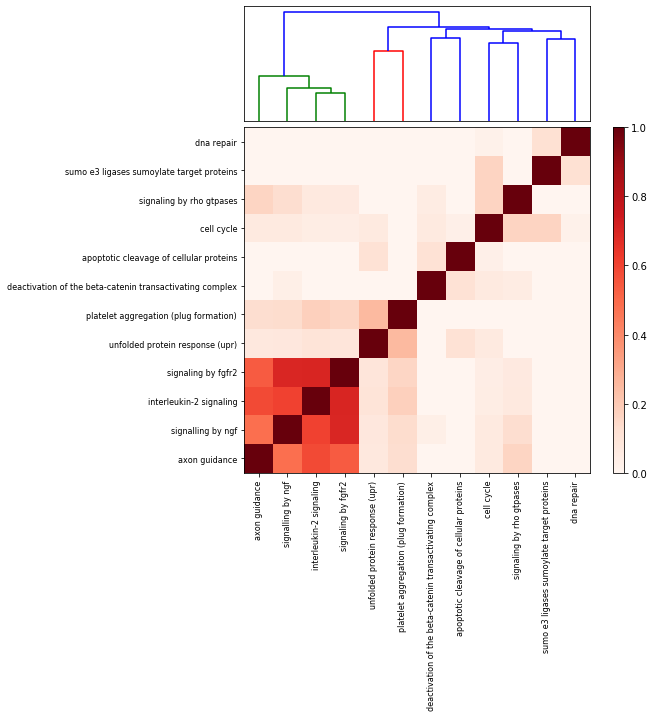

In [46]:
test_df.remove_redundant(threshold=.7, level='sample', inplace=True)
test_df.dist_matrix();

In [47]:
test_df[cols].head(25)

,term_name,rank,combined_score,n_genes,genes,sample_id
561738,cell cycle,1,36.51,28,"ACD,AKAP9,BRCA1,CDC16,CDC20,CDC7,CLASP2,DCTN1,...",01hr
561739,interleukin-2 signaling,2,30.22,16,"AKAP9,BRAF,CNKSR2,CUL3,HAVCR2,INPPL1,IRS2,MAPK...",01hr
561744,signaling by fgfr2,7,25.92,18,"AKAP9,BRAF,CNKSR2,CUL3,HNRNPA1,HNRNPM,INSR,IRS...",01hr
561746,signalling by ngf,9,25.78,21,"AKAP13,AKAP9,ARHGEF16,BRAF,CNKSR2,CUL3,HDAC1,I...",01hr
561770,axon guidance,33,20.51,22,"AKAP9,ARPC1A,BRAF,CLASP2,CLTCL1,CNKSR2,CRMP1,C...",01hr
561794,deactivation of the beta-catenin transactivati...,57,14.53,6,"APC,CBY1,CHD8,HDAC1,TLE3,YWHAZ",01hr
561800,sumo e3 ligases sumoylate target proteins,63,9.93,7,"BRCA1,NUP188,NUP88,PIAS1,SMC1A,TOP2A,TOP2B",01hr
561801,dna repair,64,9.57,12,"BRCA1,CUL4A,CUL4B,ERCC4,ERCC5,PIAS1,SLX4,USP1,...",01hr
561805,signaling by rho gtpases,68,8.90,14,"AKAP13,ARHGAP12,ARHGEF16,ARPC1A,CDC20,CLASP2,K...",01hr
561809,unfolded protein response (upr),72,8.08,6,"CALR,DCTN1,LMNA,NFYC,SHC1,TLN1",01hr


In [48]:
test_df.find_similar_terms('dna repair').head(10)

,term_name,similarity_score
6,sumo e3 ligases sumoylate target proteins,0.12
0,cell cycle,0.03
1,interleukin-2 signaling,0.00
2,signaling by fgfr2,0.00
3,signalling by ngf,0.00
4,axon guidance,0.00
5,deactivation of the beta-catenin transactivati...,0.00
7,signaling by rho gtpases,0.00
8,unfolded protein response (upr),0.00
9,platelet aggregation (plug formation),0.00


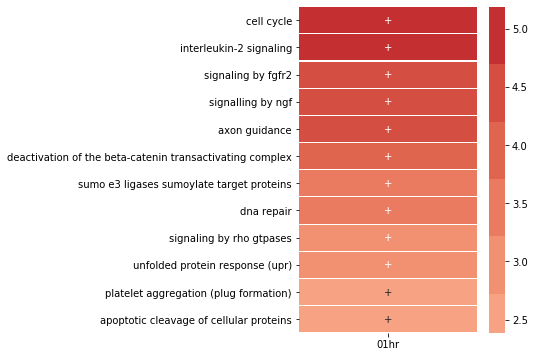

In [51]:
test_df.heatmap(convert_to_log=True, figsize=(4, 6), linewidths=.05);

In [61]:
explore = [ 'dna repair', 'cell cycle']
subset = test_df.loc[test_df['term_name'].isin(explore)].copy()
display(subset)

,term_name,rank,combined_score,adj_p_value,genes,n_genes,sample_id,category,db,significant_flag,significant
561738,cell cycle,1,36.51,2.67e-04,"ACD,AKAP9,BRCA1,CDC16,CDC20,CDC7,CLASP2,DCTN1,...",28,01hr,proteomics_up,Reactome_2016,True,True
561801,dna repair,64,9.57,3.21e-02,"BRCA1,CUL4A,CUL4B,ERCC4,ERCC5,PIAS1,SLX4,USP1,...",12,01hr,proteomics_up,Reactome_2016,True,True


In [62]:
term_net, mol_net = create_subnetwork( 
    test_df, 
    network, 
    terms = explore,
    save_name='first_time_point', 
    use_cytoscape=False,
    use_threshold=True,
    use_fdr=True
)
print(len(mol_net.nodes))
print(len(mol_net.edges))

Creating ontology network
29
31


In [63]:
view.draw_cyjs(term_net, add_parent=True)

In [64]:
view.draw_cyjs(mol_net, add_parent=True)

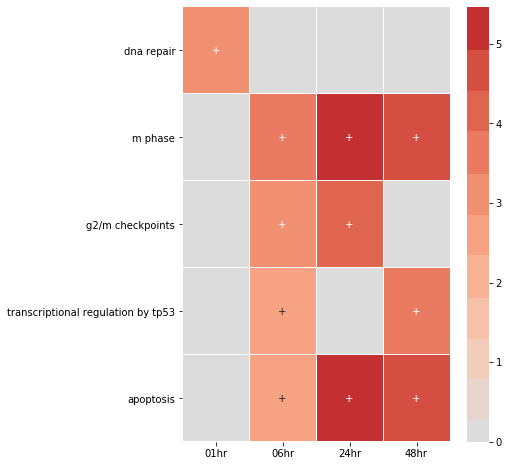

In [67]:
hits = [
        'dna repair', 
        'apoptosis',
        'transcriptional regulation by tp53', 
        'g2/m checkpoints',
        'm phase'
        ]

subset = reactome_only.loc[reactome_only['term_name'].isin(hits)].copy()
subset.heatmap(
    convert_to_log=True, 
    figsize=(6, 8), 
    linewidths=0.01,
    cluster_row=False, 
    annotate_sig=True
);

In [69]:
explore = [ 'dna repair', 'g2/m checkpoints', 'apoptosis']
subset = reactome_only.loc[reactome_only['term_name'].isin(explore)].copy()
term_net, mol_net = create_subnetwork( 
    subset, 
    network,  
    save_name='selected_from_first_tp', 
    use_cytoscape=False,
    use_threshold=True,
    use_fdr=True,
)


Creating ontology network
g2/m checkpoints apoptosis {'label': '30', 'weight': 30, 'pvalue': 1.8643252637479623e-44, 'adjPval': 7.457301054991849e-44}
g2/m checkpoints dna repair {'label': '3', 'weight': 3, 'pvalue': 0.0010408157039632686, 'adjPval': 0.0013877542719510248}
dna repair apoptosis {'label': '3', 'weight': 3, 'pvalue': 0.005215714720137629, 'adjPval': 0.005215714720137629}
dna repair g2/m checkpoints {'label': '10', 'weight': 10, 'pvalue': 1.4692800464093118e-14, 'adjPval': 2.9385600928186235e-14}


In [70]:
view.draw_cyjs(term_net, add_parent=True)


In [71]:
# mol_net = trim_sink_source_nodes(mol_net)
# mol_net = delete_disconnected_network(mol_net)
view.draw_cyjs(mol_net, add_parent=True)

## Across all time points

Number of rows went from 180 to 56
Number of rows went from 56 to 41


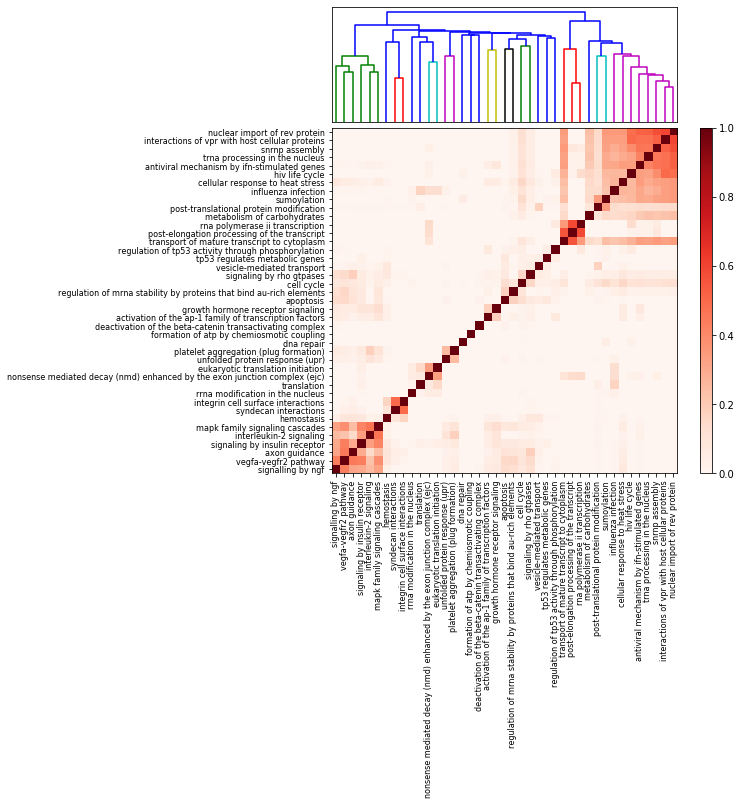

In [72]:
reactome_all_time = reactome_only.remove_redundant(threshold=.6, level='sample')
reactome_all_time.remove_redundant(threshold=.6, level='dataframe', inplace=True)
reactome_all_time.dist_matrix();

In [73]:
display(reactome_all_time[cols].head(20))

,term_name,rank,combined_score,n_genes,genes,sample_id
784046,cell cycle,5,62.05,62,"AKAP9,ATR,BANF1,CEP131,CNTRL,DIDO1,DKC1,DYNC1H...",24hr
784047,interactions of vpr with host cellular proteins,6,59.65,16,"BANF1,HMGA1,NUP107,NUP153,NUP188,NUP214,NUP35,...",24hr
902573,formation of atp by chemiosmotic coupling,7,56.68,11,"ATP5A1,ATP5B,ATP5C1,ATP5D,ATP5F1,ATP5H,ATP5I,A...",48hr
784049,transport of mature transcript to cytoplasm,8,52.93,21,"CPSF1,EIF4A3,FIP1L1,NCBP1,NUP107,NUP153,NUP188...",24hr
784050,rrna modification in the nucleus,9,52.53,19,"DDX49,DKC1,FBL,GAR1,HEATR1,IMP3,KRR1,NOL11,NOP...",24hr
902574,hemostasis,8,52.39,60,"ACTN1,ACTN4,AHSG,ALB,ALDOA,APOA1,APOH,ATP1B1,B...",48hr
784052,cellular response to heat stress,11,50.94,23,"ATR,BAG3,CAMK2D,CCAR2,GSK3B,HSF1,HSP90AA1,HSPA...",24hr
902575,vesicle-mediated transport,9,50.49,55,"ALB,APOA1,APOE,ARF4,CALR,CD59,CHMP7,COPA,COPG2...",48hr
902577,post-translational protein modification,11,48.63,56,"ARF4,CALR,CANX,CD59,COPA,COPG2,DAD1,DDOST,DERL...",48hr
784060,sumoylation,19,41.46,22,"HDAC7,HNRNPC,HNRNPK,NOP58,NSMCE2,NUP107,NUP153...",24hr


In [74]:
reactome_all_time.find_similar_terms('formation of incision complex in gg-ner').head(10)

,term_name,similarity_score
0,cell cycle,1.0
55,regulation of mrna stability by proteins that ...,1.0
63,deactivation of the beta-catenin transactivati...,1.0
62,signaling by insulin receptor,1.0
61,influenza infection,1.0
60,axon guidance,1.0
59,vegfa-vegfr2 pathway,1.0
58,tp53 regulates metabolic genes,1.0
57,post-elongation processing of the transcript,1.0
56,signaling by rho gtpases,1.0


In [75]:
reactome_all_time[reactome_all_time['term_name'] == 'apoptosis']

,term_name,rank,combined_score,adj_p_value,genes,n_genes,sample_id,category,db,significant_flag,significant
784066,apoptosis,25,36.84,1.68e-07,"ACIN1,ADD1,BAD,CASP3,DBNL,DIABLO,DSP,GSN,LMNA,...",26,24hr,proteomics_up,Reactome_2016,True,True
902600,apoptosis,34,27.67,9.52e-06,"ACIN1,APC,BAD,BCAP31,CTNNB1,DCC,DFFA,FAS,GSN,L...",23,48hr,proteomics_up,Reactome_2016,True,True
668628,apoptosis,95,7.19,3.65e-02,"ACIN1,ADD1,PAK2,PLEC,PSMA5,PSMB3,PSMD1,SPTAN1,...",11,06hr,proteomics_up,Reactome_2016,True,True


Number of rows went from 23 to 20


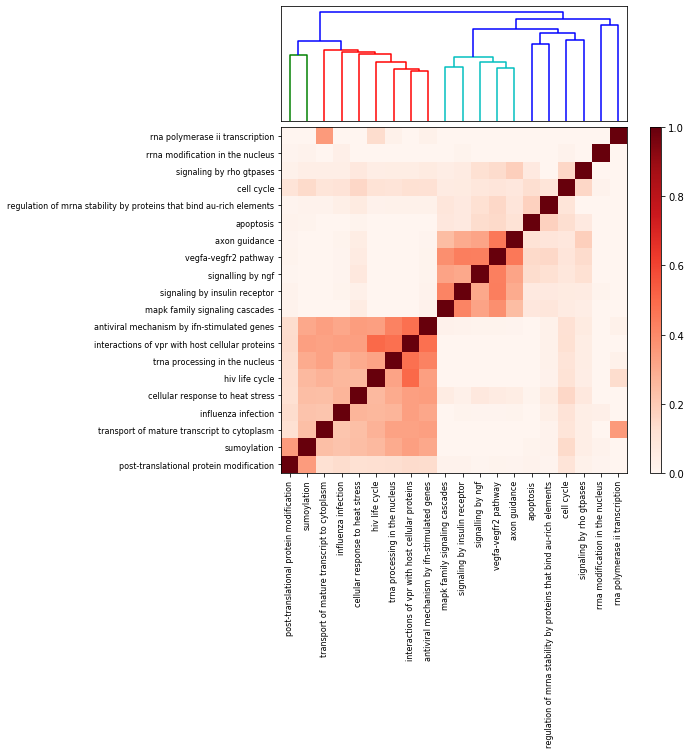

In [77]:
reactome_all_time.require_n_sig(
    index='term_name', columns='sample_id', n_sig=2,
    inplace=True
)
reactome_all_time.remove_redundant(threshold=.5, level='dataframe', inplace=True)
reactome_all_time.dist_matrix();

In [78]:
reactome_all_time.sort_values(by=['combined_score',],
                              inplace=True, 
                              ascending=False)
display(reactome_all_time[cols].head(30))

,term_name,rank,combined_score,n_genes,genes,sample_id
784046,cell cycle,5,62.05,62,"AKAP9,ATR,BANF1,CEP131,CNTRL,DIDO1,DKC1,DYNC1H...",24hr
784047,interactions of vpr with host cellular proteins,6,59.65,16,"BANF1,HMGA1,NUP107,NUP153,NUP188,NUP214,NUP35,...",24hr
784049,transport of mature transcript to cytoplasm,8,52.93,21,"CPSF1,EIF4A3,FIP1L1,NCBP1,NUP107,NUP153,NUP188...",24hr
784050,rrna modification in the nucleus,9,52.53,19,"DDX49,DKC1,FBL,GAR1,HEATR1,IMP3,KRR1,NOL11,NOP...",24hr
784052,cellular response to heat stress,11,50.94,23,"ATR,BAG3,CAMK2D,CCAR2,GSK3B,HSF1,HSP90AA1,HSPA...",24hr
902577,post-translational protein modification,11,48.63,56,"ARF4,CALR,CANX,CD59,COPA,COPG2,DAD1,DDOST,DERL...",48hr
784060,sumoylation,19,41.46,22,"HDAC7,HNRNPC,HNRNPK,NOP58,NSMCE2,NUP107,NUP153...",24hr
784061,antiviral mechanism by ifn-stimulated genes,20,40.57,18,"EIF4A3,EIF4G3,FLNB,ISG15,MAPK3,NEDD4,NUP107,NU...",24hr
902582,interactions of vpr with host cellular proteins,16,40.00,13,"BANF1,HMGA1,NDC1,NUP153,NUP188,NUP214,NUP35,NU...",48hr
902583,transport of mature transcript to cytoplasm,17,38.46,18,"DDX39B,NCBP1,NDC1,NUP153,NUP188,NUP214,NUP35,N...",48hr


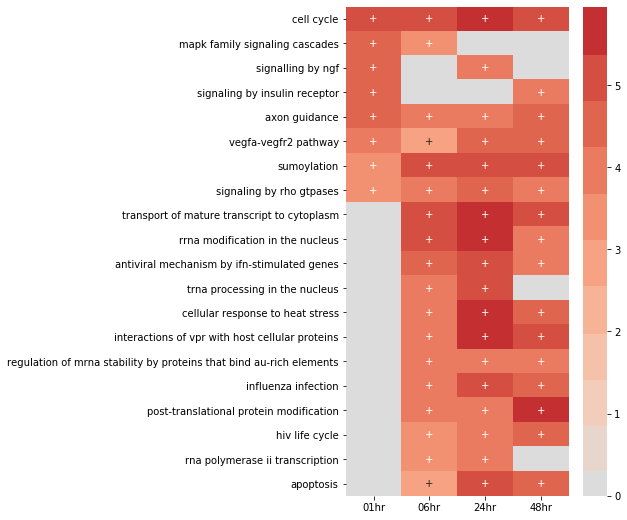

In [80]:
reactome_all_time.heatmap(
    convert_to_log=True, 
    figsize=(5, 9), 
    cluster_row=False, 
    annotate_sig=True
);

## Exploring all terms


In [82]:
term_net, mol_net = create_subnetwork( 
    reactome_all_time, network,
    terms=reactome_all_time['term_name'],  
    save_name='all_example',
    use_cytoscape=False,
    use_threshold=True
)

Creating ontology network


In [ ]:
explore = ['signalling by ngf', 'axon guidance']
subset = reactome_only.loc[reactome_only['term_name'].isin(explore)].copy()
# subset.dist_matrix();
# display(subset)
term_net, mol_net = nt.create_subnetwork( 
    subset, 
    network,
    terms=subset['term_name'],  
    save_name='ngf_axon',
    create_only=False,
    use_threshold=True
)


mol_net = trim_sink_source_nodes(network=mol_net, list_of_nodes=[])
mol_net = delete_disconnected_network(mol_net)

In [83]:
view.draw_cyjs(term_net, add_parent=True)